## Purpose and Objective

The purpose of this data mining project is to study an issue that affects healthcare economics. The objective is to understand the dataset through EDA and use various machine learning models to predic payment trends across CBSA.

In [1]:
#import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import folium
from folium.plugins import MarkerCluster

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import GammaRegressor
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.api as sm

# for Mac errors
import warnings
warnings.filterwarnings("ignore")

# %pip install -U imbalanced-learn

## Data Preprocessing

Clean and prepare data for data analysis


    1. Import Dataset
    2. Clean Data
    3. Convert Attributes
    4. Handle Null Values
    5. Handle Target Column
    6. Identify and Examine Outliers
    7. Geographical Analysis
    8. Modeling Average Payment per User

#### **1. Import Dataset**

In [2]:
# load data
full_cbsa = pd.read_csv("cbsa.csv")
full_cbsa.head(2)

,reference_period,type_of_service,aggregation_level,cbsa,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,...,average_number_of_providers_per_cbsa_dual_color,average_number_of_providers_per_cbsa_description,number_of_dual_eligible_users_dual_color,number_of_dual_eligible_users_description,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_description,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_description,total_payment_dual_color,total_payment_description
0,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,"37,359,009","9,078",424.34,10.31%,"3,852,199",...,,,,,,,,,,
1,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10100,"Aberdeen, SD","7,526",3,231,9.21%,693,...,BLUE 1,Lowest 25% (Less than 5.00 Providers),BLUE 2,Second Lowest 25% (166 - 349 Dual Eligible Users),BLUE 2,Second Lowest 25% (21.67% - 26.95% of Total Us...,BLUE 3,Third Lowest 25% (17.06% - 19.32% of Total FFS...,BLUE 2,"Second Lowest 25% ($525,929.51 - $1,042,852.56 )"


In [3]:
full_cbsa.shape

(163035, 35)

Tab-delimited text with latitude and longitude data for cbsa territories. This data will be merged with the cbsa df to visualize market saturation metrics on map for geographical analysis. The choropleth map may help see patterns across geographic regions in the United States.

In [4]:
# load geometry
geo = pd.read_csv("geo.csv")
geo['NAME'] = geo['NAME'].str.replace(' Metro Area', '').str.replace(' Micro Area', '')
geo.head()

,NAME,INTPTLAT,INTPTLONG
0,"Abilene, TX",32.452022,-99.718743
1,"Adrian, MI",41.896022,-84.074356
2,"Aguadilla, PR",18.391555,-67.097202
3,"Akron, OH",41.146639,-81.350110
4,"Albany, OR",44.488898,-122.537208


Most of the raw data will be extracted, leaving out the most columns that were derived and from the columns with raw data. This way, a separate secondary analysis is conducted without previous calculations.

In [5]:
cbsa = full_cbsa.iloc[:, :15]
cbsa.head()

,reference_period,type_of_service,aggregation_level,cbsa,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment
0,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,"37,359,009","9,078",424.34,10.31%,"3,852,199",116.56,"1,085,184",28.17%,17.24%,"$3,430,203,620.67"
1,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10100,"Aberdeen, SD","7,526",3,231,9.21%,693,3,174,25.11%,18.73%,"$588,150.97"
2,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10140,"Aberdeen, WA","17,349",18,110.44,11.46%,"1,988",18,675,33.95%,19.55%,"$1,786,700.58"
3,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10180,"Abilene, TX","25,198",11,271.09,11.83%,"2,982",11,907,30.42%,19.76%,"$2,003,346.18"
4,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10220,"Ada, OK","7,570",5,104.8,6.92%,524,5,183,34.92%,12.12%,"$359,960.14"


There are true zeros for variables in quantitative (ratio) data; therefore, calculations such as geometric mean, harmonic mean, and percent variation are valid. The reference period is a quantitative (interval) variable that will be divided from start to end for easy interpretation of continuous variables. Qualitative (nominal) variables will serve as categorical exploratory variables, allowing for operations such as mode, entropy, contingency, and correlation. As for qualitative (ordinal) variables, the 'aggregation_level' has only one unique value; thus, it will not be investigated further, as no new information can be generated from it.

<table style="border:1px solid black;">
  <tr>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Quantitative (interval)</th>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Quantitative (ratio)   </th>
  </tr>
  <tr>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">reference_period</td>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">number_of_fee_for_service_beneficiaries,
number_of_providers,
average_number_of_users_per_provider,
percentage_of_users_out_of_ffs_beneficiaries,
number_of_users,
average_number_of_providers_per_cbsa,
number_of_dual_eligible_users,
percentage_of_dual_eligible_users_out_of_total_users,
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,
total_payment
</td>
  </tr>
</table>

<table>
  <tr>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Qualitative (nominal)</th>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Qualitative (ordinal)</th>
  </tr>
  <tr>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">type_of_service,
cbsa,
cbsatitle
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">
aggregation_level
    </td>
  </tr>
</table>

#### **2. Clean Data**

Split or drop specified characters, rows, and columns for efficient referencing.

In [6]:
# remove percent and dollar signs
cbsa = cbsa.replace('%', '', regex=True)
cbsa = cbsa.replace('\$', '', regex=True)

In [7]:
# remove aggregate to remove previous calculations
cbsa = cbsa[cbsa['cbsa'] != '--ALL--']

In [8]:
# split city and state columns
cbsa[['city', 'state']] = cbsa['cbsatitle'].str.split(', ', expand=True)
cbsa.insert(0, 'state', cbsa.pop('state'))
cbsa.insert(0, 'city', cbsa.pop('city'))

In [9]:
# split reference period to start and end dates
cbsa[['start_date', 'end_date']] = cbsa['reference_period'].str.split(' to ', expand=True)
cbsa.insert(0, 'end_date', cbsa.pop('end_date'))
cbsa.insert(0, 'start_date', cbsa.pop('start_date'))
cbsa.drop(["reference_period"], axis = 1, inplace= True)

#### **3. Convert Attributes**

Convert variables to proper datatypes.

In [10]:
# convert date columns to datetime
cbsa[['start_date', 'end_date']] = cbsa[['start_date', 'end_date']].apply(pd.to_datetime)

In [11]:
# extract only the year
cbsa['year'] = cbsa['start_date'].dt.year

In [12]:
# view shape after columns created and previous calculation dropped
cbsa.shape

(162848, 19)

In [13]:
# convert numerical variables to integer or float
convert_numerical = [
    'number_of_fee_for_service_beneficiaries',
    'number_of_providers',
    'number_of_users',
    'number_of_dual_eligible_users',
    'average_number_of_users_per_provider',
    'percentage_of_users_out_of_ffs_beneficiaries',
    'average_number_of_providers_per_cbsa',
    'percentage_of_dual_eligible_users_out_of_total_users',
    'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries',
    'total_payment'
]

for column in convert_numerical:
    cbsa[column] = cbsa[column].str.replace(' ', '').str.replace(',', '')
    cbsa[column] = pd.to_numeric(cbsa[column], downcast=None)

In [14]:
# identify and convert to categorical
convert_to_category = [
    'type_of_service',
    'cbsa',
    'cbsatitle',
    'city',
    'state',
    'aggregation_level',
]
cbsa[convert_to_category] = cbsa[convert_to_category].astype('category')

In [15]:
# confirm datatypes
print(cbsa.dtypes)

start_date                                                                  datetime64[ns]
end_date                                                                    datetime64[ns]
city                                                                              category
state                                                                             category
type_of_service                                                                   category
aggregation_level                                                                 category
cbsa                                                                              category
cbsatitle                                                                         category
number_of_fee_for_service_beneficiaries                                              int64
number_of_providers                                                                  int64
average_number_of_users_per_provider                                               float64

#### **4. Handle Null Values**

In [16]:
# check null values
cbsa.isnull().sum()

start_date                                                                      0
end_date                                                                        0
city                                                                            0
state                                                                           0
type_of_service                                                                 0
aggregation_level                                                               0
cbsa                                                                            0
cbsatitle                                                                       0
number_of_fee_for_service_beneficiaries                                         0
number_of_providers                                                             0
average_number_of_users_per_provider                                         3812
percentage_of_users_out_of_ffs_beneficiaries                                    0
number_of_users 

**Investigate `average_number_of_users_per_provider`**

    - examine number of users and number of providers which were used to calculate average_number_of_users_per_provider 
    - use CMS information why provider count could be 0

In [17]:
cbsatitles_with_zero_providers = cbsa[cbsa['number_of_providers'] == 0]['cbsa']
cbsatitles_with_zero_providers

121       15100
182       17640
199       18380
208       18780
531       32260
          ...  
162967    46500
162970    46620
163006    48500
163014    48940
163028    49500
Name: cbsa, Length: 3812, dtype: category
Categories (961, object): ['10100', '10140', '10180', '10220', ..., '49700', '49740', '49780', '49820']

There are 3,812 areas that have 0 providers. Per CMS, "a provider is defined as serving a CBSA if, during the one-year reference period, the provider had paid claims for more than ten beneficiaries located in that CBSA." Verify if the number of users (FFS beneficiaries who have a paid claim for a service) per area were at least 10.

In [18]:
# check if cbsa have sufficient users to qualify
cbsa.loc[cbsa['number_of_users'] == cbsa['number_of_users'].min(),'number_of_users']

765       11
1949      11
2815      11
3288      11
3713      11
          ..
156802    11
156975    11
159581    11
162312    11
162479    11
Name: number_of_users, Length: 320, dtype: int64

**Observation:** The lowest number of user is 11, meaning the providers should be defined by CMS. Requirement is 10 and above. There appears to be many that are close to the cutoff. There may have been technicalities that did not qualify the providers according to CMS criteria. The latest information by the provider area will be calculated to replace the 3,812 providers with 0 values that do not make sense.

In [19]:
# impute number providers of 0 with previous data
cbsa['number_of_providers'].replace(0, np.nan, inplace=True)

In [20]:
# create a subset of cbsa with complete dual data
provider_subset = ['start_date','type_of_service','cbsa','number_of_providers']

cbsa_provider = cbsa[provider_subset].sort_values('start_date').dropna().drop_duplicates(
    subset=['type_of_service', 'cbsa'], keep='last')

In [21]:
# fill missing values with the most recent available data
match_cols1 = ['cbsa','type_of_service']
cbsa = cbsa.set_index(match_cols1).fillna(cbsa_provider.set_index(match_cols1)).reset_index()

In [22]:
remaining_zero_providers = cbsa[cbsa['number_of_providers'] == 0]['cbsa']
remaining_zero_providers

Series([], Name: cbsa, dtype: category
Categories (961, object): ['10100', '10140', '10180', '10220', ..., '49700', '49740', '49780', '49820'])

Due to lack of information, the remaining () will be replaced with 0s. More research is needed.

    1. How many are services with 0 providers were close to the 10 beneficiary cutoff?
    2. How many are services that are relatively new or from earlier years?
    3. How many are Telemedicine with special criteria?
    4. How many are providers that no longer operate?

In [23]:
# fill null with 0
cbsa['number_of_providers'] = cbsa['number_of_providers'].fillna(0)

**Investigate `number_of_dual_eligible_users`**

    - replace missing values with same data from the most recent previous reference period
    - estimate number of dual eligible using average qualifiers per type of sertice

In [24]:
# create a subset of cbsa with complete dual data
dual_subset = ['start_date','type_of_service','cbsa','number_of_dual_eligible_users']

cbsa_dual = cbsa[dual_subset].sort_values('start_date').dropna().drop_duplicates(
    subset=['type_of_service', 'cbsa'], keep='last')

In [25]:
# fill missing values with the most recent available data
match_cols2 = ['cbsa','type_of_service']
cbsa = cbsa.set_index(match_cols2).fillna(cbsa_dual.set_index(match_cols2)).reset_index()

The estimate of missing dual eligible users data is the average number of dual users per service type.

In [26]:
# aggregate mean of percentage_of_dual_eligible_users_out_of_total_users per service type

mean_percentage_service = cbsa.groupby('type_of_service')['percentage_of_dual_eligible_users_out_of_total_users'].mean()
mean_percentage_service = mean_percentage_service.reset_index()
mean_percentage_service

,type_of_service,percentage_of_dual_eligible_users_out_of_total_users
0,Ambulance (Emergency & Non-Emergency),27.484972
1,Ambulance (Emergency),27.981974
2,Ambulance (Non-Emergency),29.584675
3,Cardiac Rehabilitation Program,12.125258
4,Chiropractic Services,8.943611
5,Clinical Laboratory (Billing Independently),18.059210
6,Dialysis,39.513165
7,Federally Qualified Health Center (FQHC),45.332903
8,Home Health,21.352746
9,Hospice,20.758439


In [27]:
# fill missing values with average percentage
match_mean_dual_service = ['type_of_service']
cbsa = cbsa.set_index(match_mean_dual_service).fillna(mean_percentage_service.set_index(match_mean_dual_service)).reset_index()

In [28]:
# fill nulls of average_number_of_users_per_provider with num users/num providers
fill_avg_users_per_provider = cbsa['number_of_users']/cbsa['number_of_providers']
cbsa['average_number_of_users_per_provider'].fillna(fill_avg_users_per_provider, inplace=True)
cbsa['average_number_of_users_per_provider'].replace(np.inf, 0, inplace=True)

In [29]:
# fill nulls of number_of_dual_eligible_users by average number per service type
fill_dual_users = cbsa['number_of_users']*(cbsa[
    'percentage_of_dual_eligible_users_out_of_total_users']/100)
cbsa['number_of_dual_eligible_users'].fillna(fill_dual_users, inplace=True)

In [30]:
cbsa['percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries'] = cbsa[
    'number_of_dual_eligible_users']/cbsa['number_of_fee_for_service_beneficiaries']

In [31]:
# check null values
cbsa.isnull().sum()

type_of_service                                                             0
cbsa                                                                        0
start_date                                                                  0
end_date                                                                    0
city                                                                        0
state                                                                       0
aggregation_level                                                           0
cbsatitle                                                                   0
number_of_fee_for_service_beneficiaries                                     0
number_of_providers                                                         0
average_number_of_users_per_provider                                        0
percentage_of_users_out_of_ffs_beneficiaries                                0
number_of_users                                                 

In [32]:
users_per_service = cbsa.groupby('type_of_service')['number_of_users'].sum().reset_index()
users_per_service_sorted = users_per_service.sort_values(by='number_of_users', ascending=False)
users_per_service_sorted

,type_of_service,number_of_users
16,Preventive Health Services,169223762
10,Independent Diagnostic Testing Facility Pt A,134015716
5,Clinical Laboratory (Billing Independently),124559121
13,Ophthalmology,97240318
18,Pulmonology,65158266
15,Podiatry Services,38730450
0,Ambulance (Emergency & Non-Emergency),31901593
1,Ambulance (Emergency),28738527
14,Physical & Occupational Therapy,24448431
8,Home Health,22853273


In [33]:
# label encoder object
label_encoder = LabelEncoder()

# create encoded column for heatmap in modeling section
cbsa['type_of_service_encoded'] = label_encoder.fit_transform(cbsa['type_of_service'])
# cbsa

In [34]:
le_services = cbsa['type_of_service_encoded'].unique()
le_services

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

21 service types encoded, matching the available service types.

In [35]:
unique_states = cbsa['state'].unique()
unique_states

['SD', 'WA', 'TX', 'OK', 'MI', ..., 'VA-NC', 'DC-VA-MD-WV', 'VA-WV', 'MA-CT', 'OH-PA']
Length: 102
Categories (102, object): ['AK', 'AL', 'AL-GA', 'AR', ..., 'WV-OH', 'WV-VA', 'WY', 'WY-ID']

**Observation:** some providers were 0 and therfefore error calculating `average_number_of_users_per_provider`.

Number of Fee-For-Service (FFS) Beneficiaries, Number of Providers, Number of Users, Number of Dual Eligible Users, Total Payment, reference_period, type_of_service, cbsa

All service types will be aggregated, box plot, compared by payment. Isolate and examine which has the most outliers.

#### **5. Handle `average_payment_per_user` to ensure  comparability across CBSA**

The target variable, `average_payment_per_user` is a standardized metric calculated by the average of `total_payment` over the `number_of_users`. This metric accounts for difference in number of users across cbsa which could be meaningful when assessing cost-effectiveness or fraud. The understanding of the average cost per unit of service can help in comparing efficiency across different cbsa. The limitation of using this target variable is the differences in service popularity which can fluctuate over time or beneficiary health status.

$$ \text{Average Payment per User} = \frac{\text{Total Payment * Cost of Health Index}}{\text{Number of Users}} $$

    - The total payment will be adjusted by state cost of health index
    - Then, the total will be divided by the number of users

**Apply Cost of Health Index to `total_payment`**

In [36]:
# cost of health index dictionary
cost_index = {
    'AK' : 1.48, 'AL' : 0.87, 'AL-GA' : 0.87, 'AR' : 0.88, 'AR-MO' : 0.88, 
    'AR-OK' : 0.88, 'AZ' : 0.94, 'CA' : 1.09, 'CO' : 1.00, 'CT' : 1.09, 
    'DC-VA-MD-WV' : 1.47, 'DE' : 1.03, 'FL' : 0.97, 'GA' : 1.00, 
    'GA-AL' : 1.00, 'GA-SC' : 0.91, 'HI' : 1.23, 'IA' : 0.99, 
    'IA-IL' : 0.99, 'IA-IL-MO' : 0.99, 'IA-NE-SD' : 0.99, 'ID' : 0.99, 
    'ID-WA' : 0.99, 'IL' : 0.95, 'IL-IN-WI' : 0.95, 'IL-MO' : 0.95, 
    'IN' : 0.96, 'IN-KY' : 0.96, 'IN-MI' : 0.96, 'KS' : 0.97, 'KY' : 0.84, 
    'KY-IL' : 0.84, 'KY-IN' : 0.84, 'LA' : 0.99, 'MA' : 1.13, 'MA-CT' : 1.13, 
    'MA-NH' : 1.13, 'MD' : 0.97, 'MD-DE' : 0.97, 'MD-WV' : 0.97, 'ME' : 1.03, 
    'MI' : 0.93, 'MI-WI' : 0.93, 'MN' : 1.09, 'MN-WI' : 1.09, 'MO' : 0.90, 
    'MO-IL' : 0.90, 'MO-KS' : 0.90, 'MS' : 0.98, 'MS-LA' : 0.98, 'MT' : 0.98, 
    'NC' : 1.08, 'NC-SC' : 1.08, 'ND' : 1.11, 'ND-MN' : 1.11, 'NE' : 0.98, 
    'NE-IA' : 0.98, 'NH' : 1.13, 'NH-VT' : 1.13, 'NJ' : 0.99, 'NM' : 0.99, 
    'NV' : 0.92, 'NY' : 1.06, 'NY-NJ-PA' : 1.06, 'OH' : 0.98, 'OH-KY-IN' : 0.98, 
    'OH-PA' : 0.98, 'OK' : 0.93, 'OR' : 1.05, 'OR-ID' : 1.05, 'OR-WA' : 1.05, 
    'PA' : 0.94, 'PA-NJ' : 0.96, 'PA-NJ-DE-MD' : 0.94, 'PR' : 0.69, 'RI-MA' : 1.08, 
    'SC' : 0.95, 'SC-NC' : 0.95, 'SD' : 0.98, 'TN' : 0.88, 'TN-GA' : 0.88, 
    'TN-KY' : 0.88, 'TN-MS-AR' : 0.88, 'TN-VA' : 0.88, 'TX' : 0.94, 'TX-AR' : 0.94, 
    'UT' : 0.91, 'UT-ID' : 0.91, 'VA' : 1.02, 'VA-NC' : 1.02, 'VA-WV' : 1.02, 
    'VT' : 1.06, 'WA' : 1.20, 'WI' : 1.12, 'WI-MI' : 1.12, 'WI-MN' : 1.12, 'WV' : 0.97, 
    'WV-KY-OH' : 0.97, 'WV-OH' : 0.97, 'WV-VA' : 0.97, 'WY' : 1.00, 'WY-ID' : 1.00
}

In [37]:
# use dictionary to map states to their cost of health index
cbsa['cost_of_health_index'] = cbsa['state'].map(cost_index)
cbsa['total_payment_adjusted'] = cbsa['total_payment']*cbsa['cost_of_health_index']

**Normalize `total_payment_adjusted` by health service utilization**

In [38]:
# create column for normalized total payment
cbsa['target_payment'] = cbsa['total_payment_adjusted']/cbsa['number_of_users']

In [39]:
# statistics
cbsa.describe()

,start_date,end_date,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,year,type_of_service_encoded,cost_of_health_index,total_payment_adjusted,target_payment
count,162848,162848,1.628480e+05,162848.000000,162848.000000,162848.000000,1.628480e+05,162848.000000,162848.000000,162848.000000,162848.000000,1.628480e+05,162848.000000,162848.000000,162848.00000,1.628480e+05,162848.000000
mean,2019-01-12 09:51:07.144822016,2020-01-11 15:09:18.145018624,3.876744e+04,50.151767,113.162370,12.941694,5.105435e+03,50.072258,930.209669,23.232540,0.023898,1.158631e+07,2019.030931,9.925323,0.98537,1.171921e+07,8359.039088
min,2015-01-01 00:00:00,2015-12-31 00:00:00,4.070000e+02,0.000000,0.000000,0.010000,1.100000e+01,0.000000,0.983797,0.470000,0.000022,5.953100e+02,2015.000000,0.000000,0.69000,4.107639e+02,26.666471
25%,2017-01-01 00:00:00,2017-12-31 00:00:00,6.180000e+03,4.000000,41.000000,2.560000,2.380000e+02,4.000000,47.000000,12.730000,0.004694,2.189874e+05,2017.000000,5.000000,0.94000,2.141422e+05,249.431556
50%,2019-01-01 00:00:00,2019-12-31 00:00:00,1.196600e+04,10.000000,64.960000,5.890000,8.010000e+02,10.000000,159.000000,20.240000,0.012421,9.170519e+05,2019.000000,10.000000,0.98000,8.994380e+05,652.130172
75%,2021-01-01 00:00:00,2021-12-31 00:00:00,2.689500e+04,28.000000,128.000000,15.610000,2.830000e+03,28.000000,517.000000,30.780000,0.030779,4.449768e+06,2021.000000,15.000000,1.02000,4.411305e+06,5864.095093
max,2023-01-01 00:00:00,2023-12-31 00:00:00,2.523066e+06,16732.000000,2581.130000,75.080000,1.421406e+06,16732.000000,231507.000000,100.000000,0.496762,6.625352e+09,2023.000000,20.000000,1.48000,7.022873e+09,358333.097520
std,NaN,NaN,1.176749e+05,278.113821,136.809881,15.949473,2.603557e+04,278.108241,5092.474592,13.727376,0.031046,8.285980e+07,2.570610,6.044600,0.08800,8.663620e+07,18017.080283


In [40]:
# define handled target column
target_col = 'target_payment'

#### **6. Identify and Examine Outliers**

Outliers Removed Based on Interquartile Range

In [41]:
def remove_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)]

grouped = cbsa.groupby('type_of_service')
cbsa_outliers_removed = grouped.apply(remove_outliers, target_col)
cbsa_outliers_removed = cbsa_outliers_removed.reset_index(drop=True)

In [42]:
print(len(cbsa)-len(cbsa_outliers_removed), "outliers removed from CBSA")

5715 outliers removed from CBSA


In [43]:
# replace original cbsa with outliers removed
cbsav2 = cbsa_outliers_removed

## Data Visualization

    1. Payment Trends
    2. Box Plot of Average Payment per User
    3. Visualize ratio of users to providers across CBSA

#### **1. Payment Trends**

In [44]:
# Filter the DataFrame by year == 2023
cbsa_2023 = cbsa[cbsa['year'] == 2023]

In [45]:
users_2023 = cbsa_2023.groupby('type_of_service')['number_of_users'].sum()
users_2023 = users_2023.sort_values(ascending=True).reset_index()
users_2023

,type_of_service,number_of_users
0,Long-Term Care Hospitals,34047
1,Cardiac Rehabilitation Program,125082
2,Dialysis,210112
3,Hospice,728565
4,Skilled Nursing Facility,1015407
5,Ambulance (Non-Emergency),1078184
6,Chiropractic Services,1147640
7,Federally Qualified Health Center (FQHC),1183333
8,Telemedicine,1185208
9,Psychotherapy,1658103


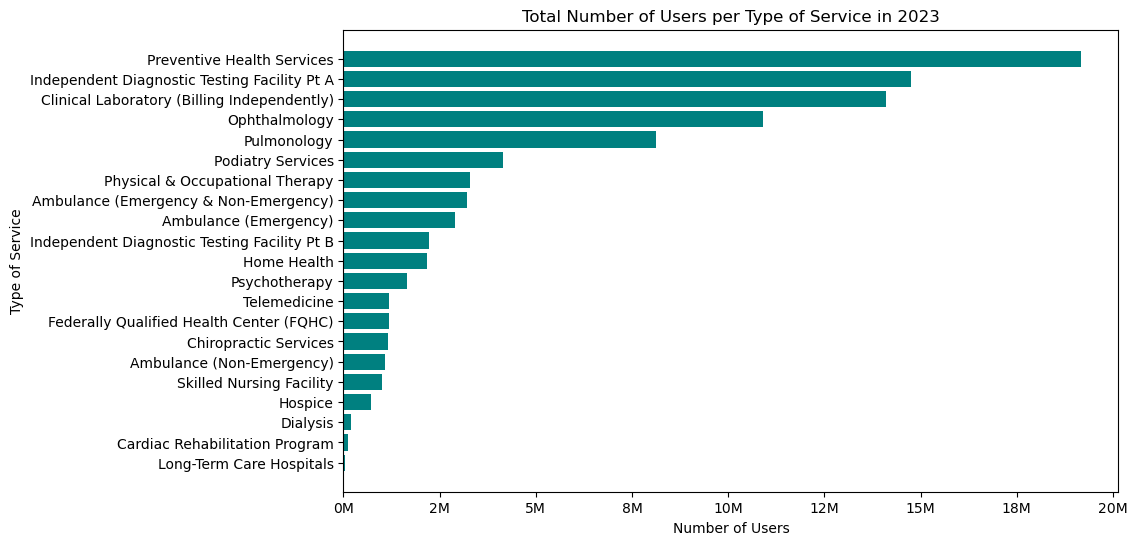

In [46]:
# Group by 'type_of_service' and calculate the sum of 'number_of_users'
users_per_service_2023 = cbsa_2023.groupby('type_of_service')['number_of_users'].sum().reset_index()

# Sort the values if needed
users_per_service_2023_sorted = users_per_service_2023.sort_values(by='number_of_users', ascending=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(users_per_service_2023_sorted['type_of_service'], users_per_service_2023_sorted['number_of_users'], color='teal')
plt.xlabel('Number of Users')
plt.ylabel('Type of Service')
plt.title('Total Number of Users per Type of Service in 2023')
# format x-axis for readability
def format_dollars(x, pos):
    return '{:,.0f}M'.format(x / 1e6)
    
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))
plt.show()

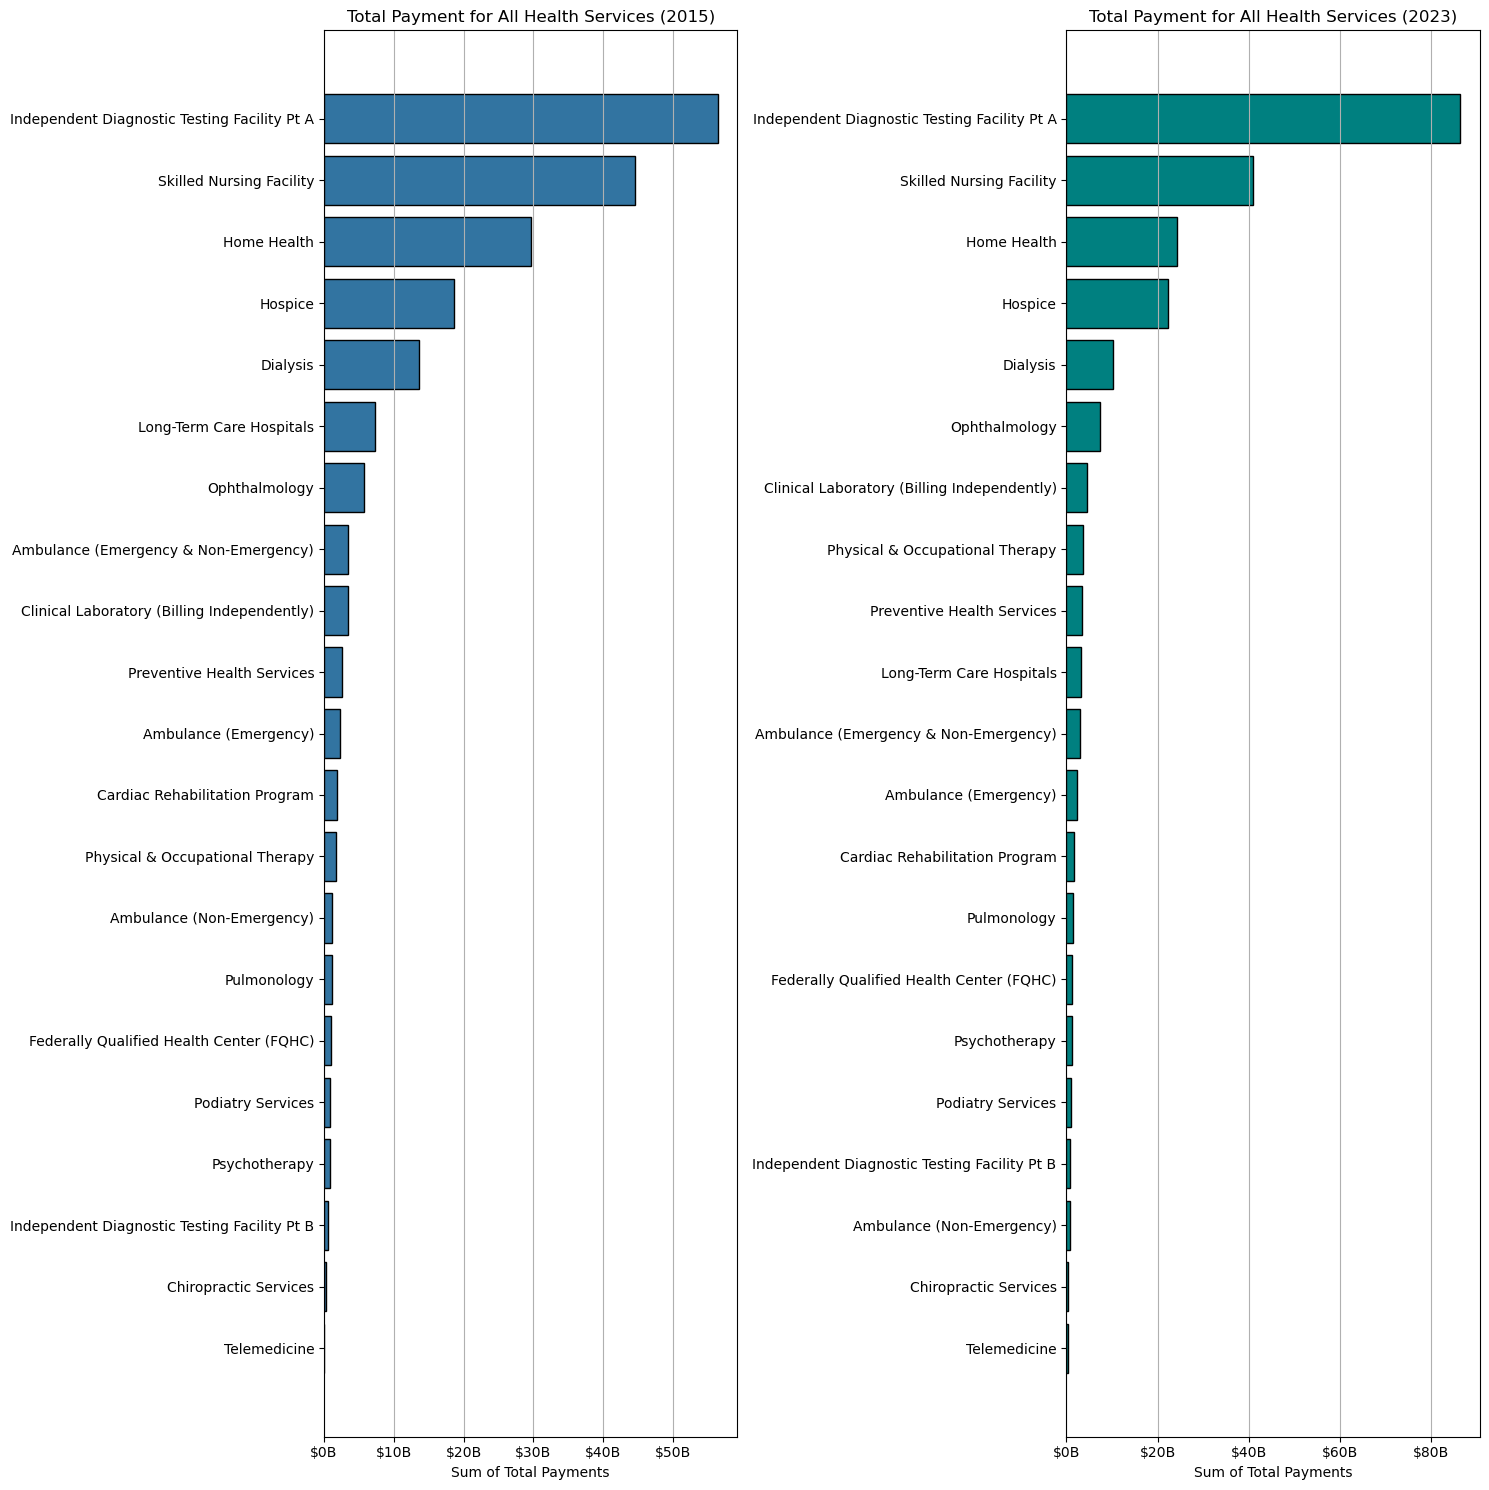

In [47]:
def filter_and_group_by_year(cbsa, year):
    cbsa_year = cbsa[cbsa['year'] == year]
    service_payment_year = cbsa_year.groupby('type_of_service', as_index=False)['total_payment'].sum()
    service_payment_year.sort_values(by='total_payment', inplace=True)
    return service_payment_year

def plot_service_payment(service_payment, title, color, ax):
    ax.yaxis.grid(False)
    ax.xaxis.grid(True)
    ax.barh(service_payment['type_of_service'], service_payment['total_payment'], color=color, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel("Sum of Total Payments")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

# Format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}B'.format(x / 1e9)
    
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

service_payment_2015 = filter_and_group_by_year(cbsa, 2015)
plot_service_payment(service_payment_2015, "Total Payment for All Health Services (2015)", '#3274a1', axs[0])

service_payment_2023 = filter_and_group_by_year(cbsa, 2023)
plot_service_payment(service_payment_2023, "Total Payment for All Health Services (2023)", 'teal', axs[1])

plt.tight_layout()
plt.show()

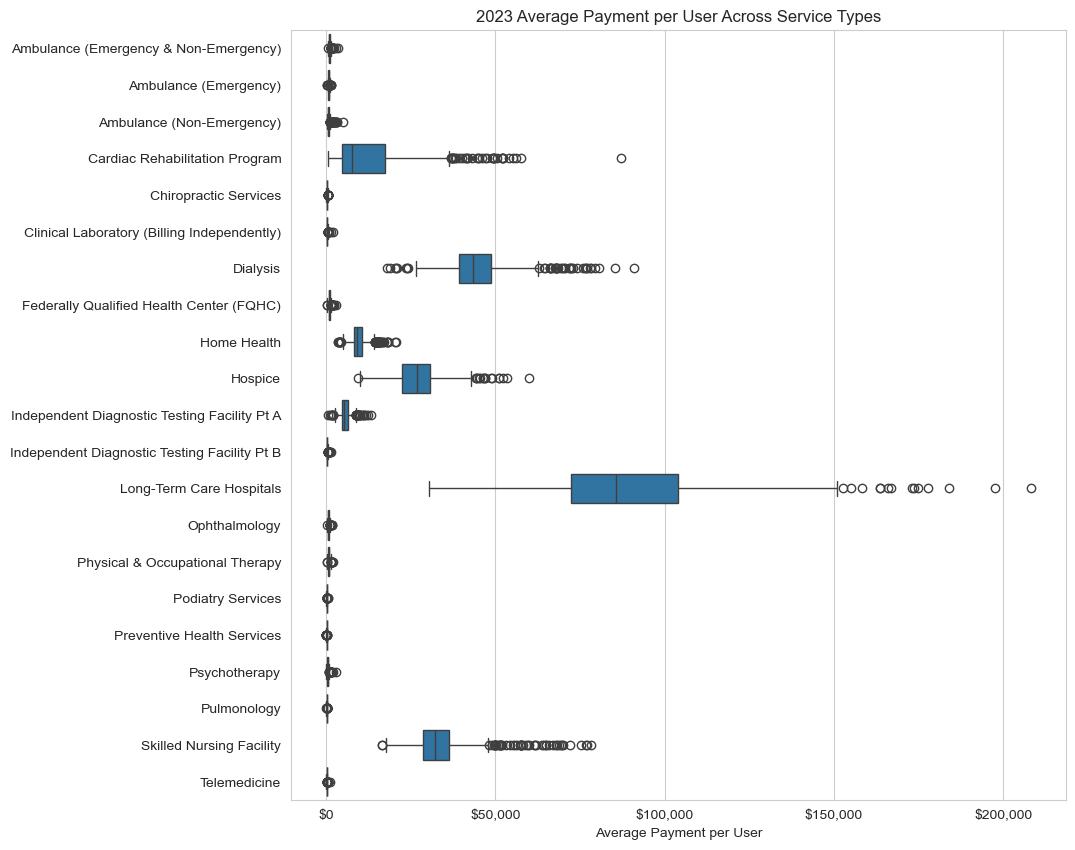

In [48]:
# grid for all visualizations
ax2 = sns.set_style("whitegrid")

# readability
plt.figure(figsize=(10,10))

# horizontal boxplot for 2023
ax2 = sns.boxplot(y='type_of_service', x='target_payment', 
    data=cbsa[cbsa['year'] == 2023])

# labels
ax2.set_title('2023 Average Payment per User Across Service Types')
ax2.set_xlabel('Average Payment per User')
ax2.set_ylabel('')

# format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}'.format(x)
    
# apply format
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))
plt.show()

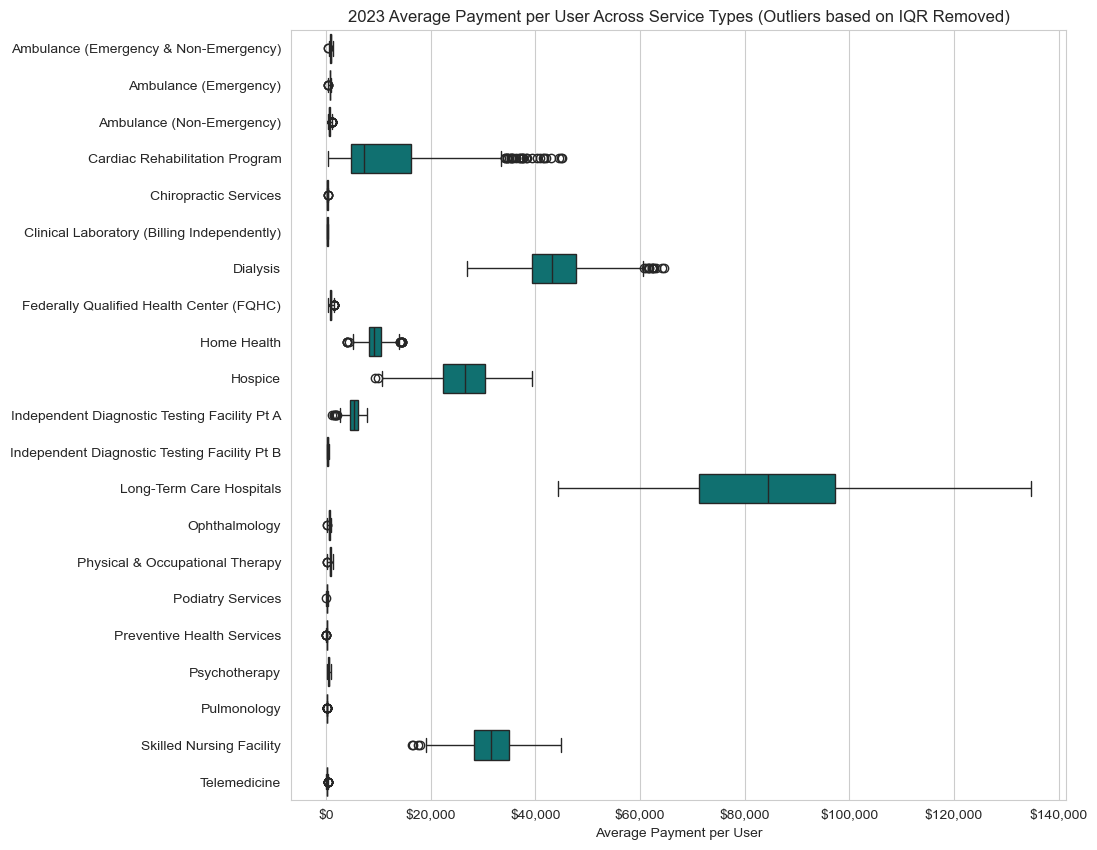

In [49]:
# readability
plt.figure(figsize=(10,10))
ax3 = sns.set_style("whitegrid")

# horizontal boxplot for 2023
ax3 = sns.boxplot(y='type_of_service', x='target_payment', 
    data=cbsav2[cbsav2['year'] == 2023],
    color='teal')

# labels
ax3.set_title('2023 Average Payment per User Across Service Types (Outliers based on IQR Removed)')
ax3.set_xlabel('Average Payment per User')
ax3.set_ylabel('')

# format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}'.format(x)
    
# apply format
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))
plt.show()

To account for unusual Medicare user circumstances, unusual high total payments (outliers) will be kept through modeling despite positively skewing the data. For future analysis, these particular outlier CBSAs require investigation.

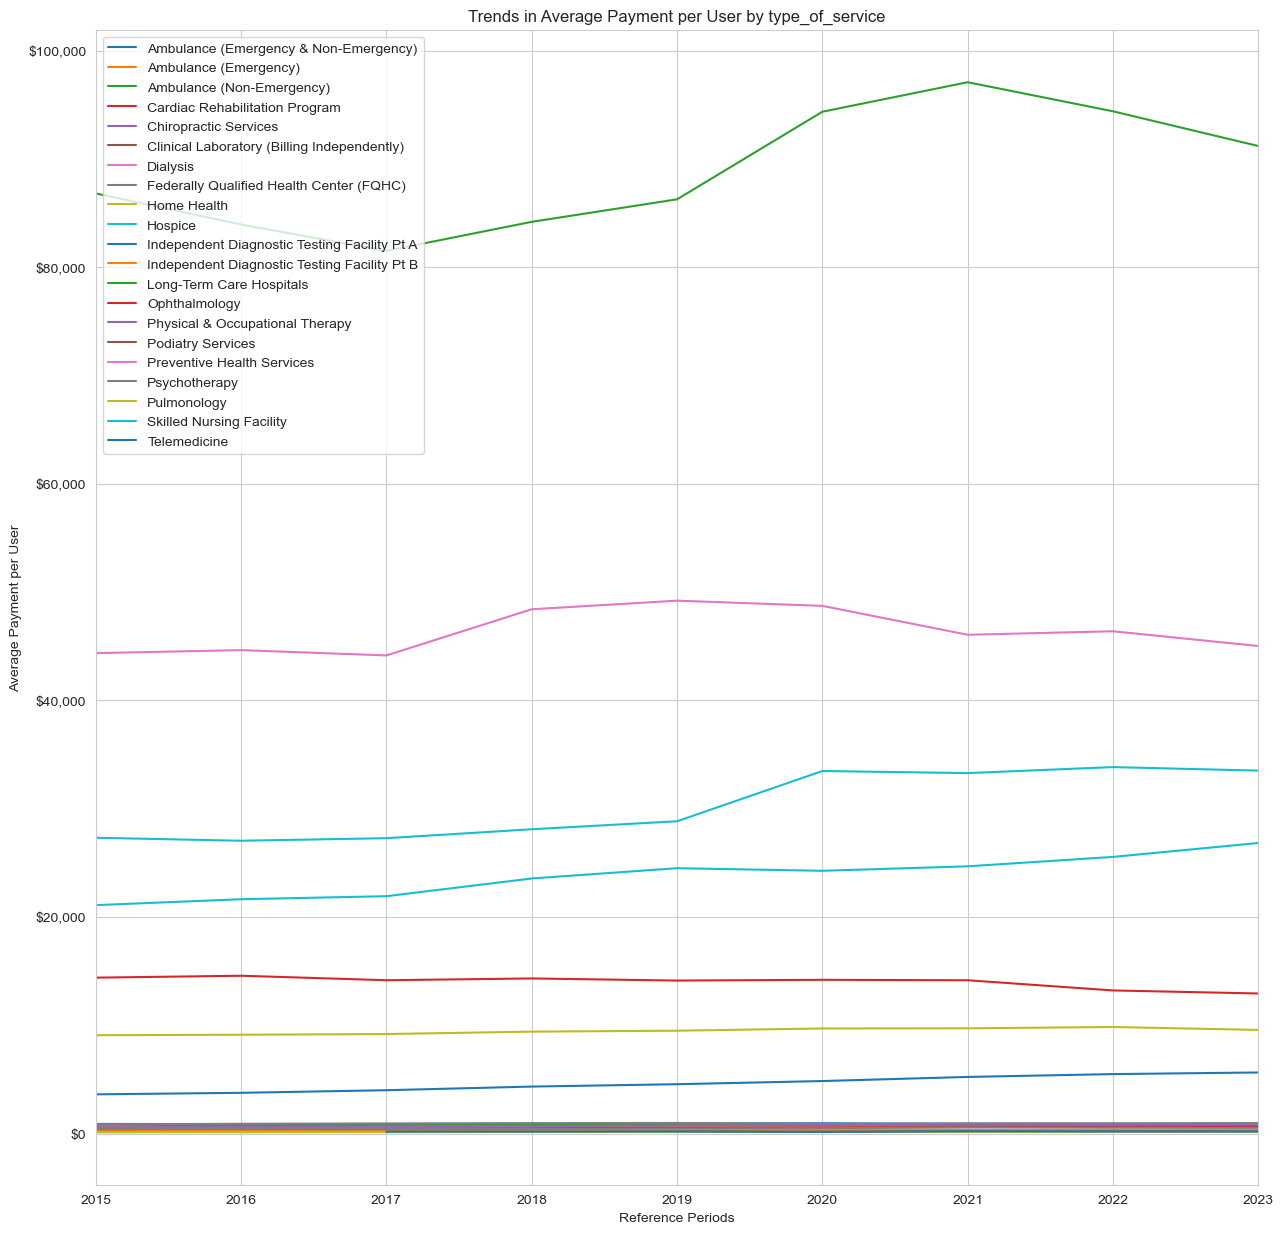

In [50]:
# groupby type_of_service and start_date
# calculate the mean of target for each group
trend1 = cbsa.groupby(['type_of_service', 'start_date']).agg({target_col: 'mean'})

# isolate unique services
type_of_service_trends = cbsa['type_of_service'].unique()

# size
plt.figure(figsize=(15, 15))

# line plot each type_of_service
for type_of_service in type_of_service_trends:
    type_of_service_data = trend1.loc[type_of_service]
    type_of_service_data['target_payment'].plot(label=type_of_service)

# labels
plt.xlabel('Reference Periods')
plt.ylabel('Average Payment per User')
plt.title('Trends in Average Payment per User by type_of_service')

# legend
plt.legend(loc='upper left')

# format y-axis for readability
def format_dollars(y, pos):
    return '${:,.0f}'.format(y)
    
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))
plt.show()

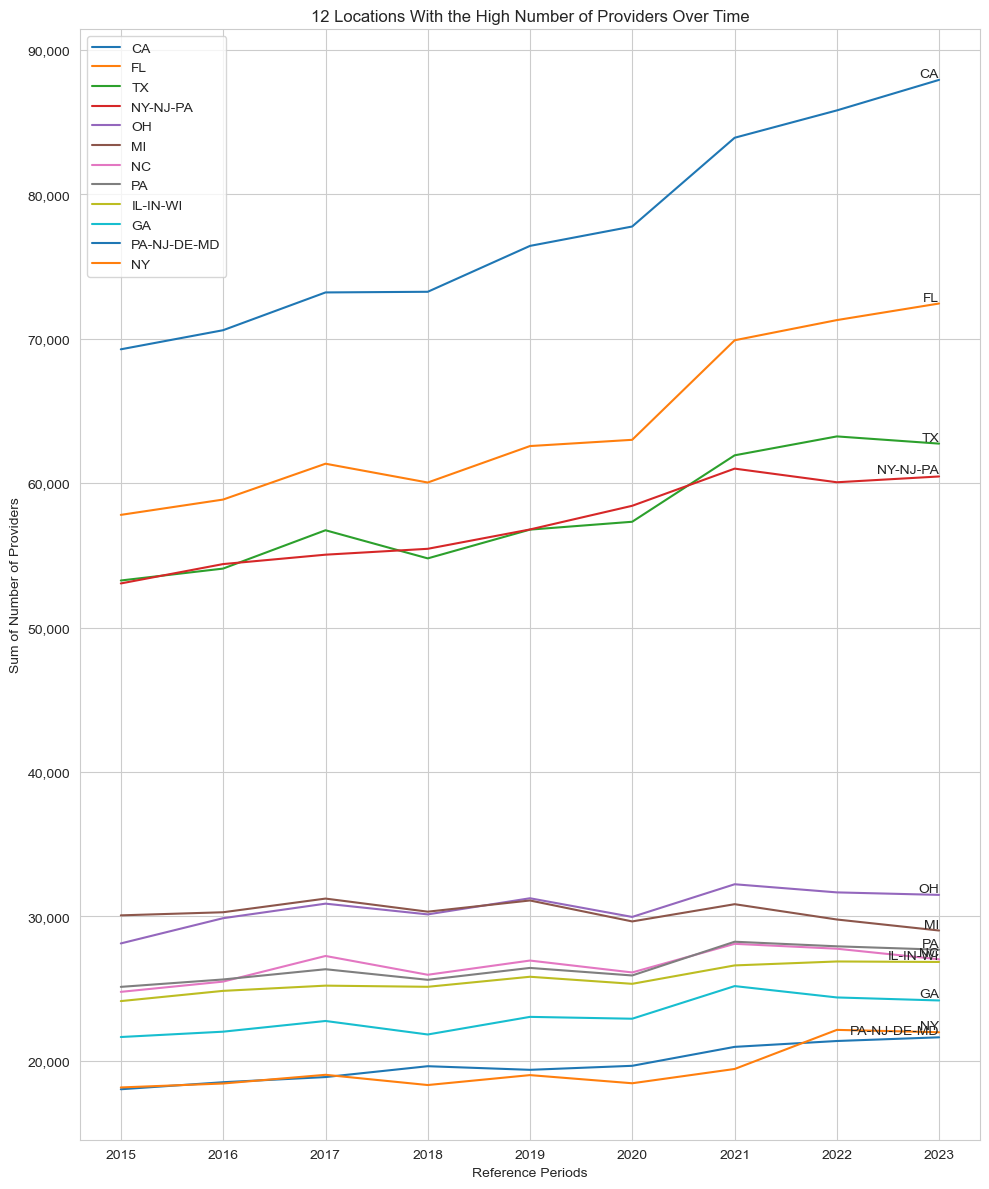

In [51]:
# groupby state and start date
# calculate the sum of 'number_of_providers' for each group
trend2 = cbsa.groupby(['state', 'start_date'])['number_of_providers'].sum().reset_index()

# total number of providers for each state
total_providers_by_state = trend2.groupby('state')['number_of_providers'].sum()

# top 5 states with the highest total number of providers
top_12_states = total_providers_by_state.nlargest(12).index

# size
plt.figure(figsize=(10, 12))

# line plot the sum of 'number_of_providers' over time for each state
for state in top_12_states:
    state_data = trend2[trend2['state'] == state]
    plt.plot(state_data['start_date'], state_data['number_of_providers'], label=state)

    # annotate line
    last_data_point = state_data.iloc[-1]
    plt.text(last_data_point['start_date'], last_data_point['number_of_providers'], state, ha='right', va='bottom')

# labels
plt.xlabel('Reference Periods')
plt.ylabel('Sum of Number of Providers')
plt.title('12 Locations With the High Number of Providers Over Time')

# legend
plt.legend(loc='upper left')

# format y-axis for readability
def format_dollars(y, pos):
    return '{:,.0f}'.format(y)
    
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

# improve readability
plt.tight_layout()
plt.show()

In [52]:
covariance = cbsa[['total_payment', 'number_of_providers']].cov().iloc[0, 1]

print("Covariance between 'total_payment' and 'number_of_providers':", covariance)

Covariance between 'total_payment' and 'number_of_providers': 2452433083.278495


The covariance is positive, suggesting that `total_payment` increases along with the `number_of_providers` increases.

In [53]:
covariance = cbsa[['total_payment', 'cost_of_health_index']].cov().iloc[0, 1]

print("Covariance between 'total_payment' and 'number_of_providers':", covariance)

Covariance between 'total_payment' and 'number_of_providers': 302406.4619536688


In [54]:
correlation = cbsa[['total_payment', 'cost_of_health_index']].corr()
correlation

,total_payment,cost_of_health_index
total_payment,1.000000,0.041473
cost_of_health_index,0.041473,1.000000


#### **2. Visualize ratio of users to providers across CBSA**


Visualize `average_number_of_users_per_provider` across CBSA with folium.

$$ \text{Ratio} = \frac{ \text{number of providers} }{ \text{number of users} } $$

In [55]:
# merge datasets based on 'cbsatitle'
geo_merged = cbsa.merge(geo[['NAME', 'INTPTLAT', 'INTPTLONG']], left_on='cbsatitle', right_on='NAME', how='left')

# drop the duplicated 'NAME' column
geo_merged.drop('NAME', axis=1, inplace=True)

geo_merged.shape

(162848, 25)

In [56]:
null_geometry = geo_merged[geo_merged['INTPTLAT'].isnull() | geo_merged['INTPTLONG'].isnull()]
null_geometry.shape[0]

0

In [57]:
cbsatitles_with_zero_providers = cbsa[cbsa['number_of_providers'] == 0]['cbsa']

cbsatitles_with_zero_providers

764       42180
1117      17640
1134      18380
2822      14180
2937      21260
          ...  
162168    19540
162249    23140
162332    26780
162502    34300
162841    49500
Name: cbsa, Length: 986, dtype: category
Categories (961, object): ['10100', '10140', '10180', '10220', ..., '49700', '49740', '49780', '49820']

In [58]:
# subset most recent data from 2023
geo_merged_2023 = geo_merged[geo_merged['year'] == 2023]

# subset zero providers
zero_providers = geo_merged_2023[geo_merged_2023['number_of_providers'] == 0][['cbsatitle','INTPTLAT', 'INTPTLONG', 'number_of_providers']]

# subset providers per geo mapped cbsatitle
providers_per_cbsatitle = geo_merged_2023.groupby('cbsatitle')[['INTPTLAT', 'INTPTLONG', 'number_of_providers']].first().reset_index()

# count beneficiaries per cbsa
beneficiaries_count = geo_merged_2023.groupby(['cbsatitle', 'INTPTLAT', 'INTPTLONG'])['number_of_fee_for_service_beneficiaries'].count().reset_index()

In [59]:
# subset most recent data from 2023
geo_merged_2023 = geo_merged[geo_merged['year'] == 2023]

# subset zero providers
zero_providers = geo_merged_2023[geo_merged_2023['number_of_providers'] == 0][['cbsatitle','INTPTLAT', 'INTPTLONG', 'number_of_providers']]

# subset providers per geo mapped cbsatitle
providers_per_cbsatitle = geo_merged_2023.groupby('cbsatitle')[['INTPTLAT', 'INTPTLONG', 'number_of_providers']].first().reset_index()

# count beneficiaries per cbsa
beneficiaries_count = geo_merged_2023.groupby(['cbsatitle', 'INTPTLAT', 'INTPTLONG'])['number_of_fee_for_service_beneficiaries'].count().reset_index()

In [60]:
# USA default
site_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# MarkerCluster object for clustering markers
marker_cluster_with_providers = MarkerCluster().add_to(site_map)

# for every row in subset that meet condition, add to marker_cluster_with_providers object
for idx, row in providers_per_cbsatitle.iterrows():
    cbsatitle = row['cbsatitle']
    INTPTLAT = row['INTPTLAT']
    INTPTLONG = row['INTPTLONG']
    num_providers = row['number_of_providers']
    tooltip = f"{cbsatitle}: {num_providers} providers"
    if num_providers > 0:
        marker = folium.Marker(
            location=[INTPTLAT, INTPTLONG],
            popup=f"{cbsatitle}: {num_providers} providers",
            tooltip=tooltip,
        )
        marker.add_to(marker_cluster_with_providers)

# for every row in subset that meet condition, add CircleMarker
for idx, row in zero_providers.iterrows():
    cbsatitle = row['cbsatitle']
    INTPTLAT = row['INTPTLAT']
    INTPTLONG = row['INTPTLONG']
    num_providers = row['number_of_providers']
    tooltip = f"{cbsatitle}: {num_providers} providers"
    folium.CircleMarker(
        location=[INTPTLAT, INTPTLONG],
        radius=5,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.4,
        tooltip=tooltip
        ).add_to(site_map)

# for every row in subset that meet condition, add CircleMarker
for idx, row in beneficiaries_count.iterrows():
    cbsatitle = row['cbsatitle']
    INTPTLAT = row['INTPTLAT']
    INTPTLONG = row['INTPTLONG']
    num_beneficiaries = row['number_of_fee_for_service_beneficiaries']
    folium.CircleMarker(
        location=[INTPTLAT, INTPTLONG],
        radius=1,
        color='teal',
        fill=True,
        fill_color='teal',
        fill_opacity=0.4,
        tooltip=tooltip
        ).add_to(site_map)
        
# Display the map
site_map

| Marker Color | Description                                                                                     |
|--------------|-------------------------------------------------------------------------------------------------|
| <font color="teal">**Teal**</font>        | Teal markers indicate aggregate of beneficiaries enrolled in a fee-for-service healthcare program within a CBSA.                |
| <font color="green">**Green**</font>        | Green markers indicate areas with a high number of providers or good conditions.                |
| <font color="orange">**Yellow**</font>       | Orange markers indicate areas with a moderate number of providers or intermediate conditions.   |
| <font color="blue">**Blue**</font>         | Blue markers represent unclustered default or baseline state. May indicate areas with a low number of providers or poor conditions.                                               |
| <font color="purple">**Purple**</font>       | Purple markers indicate locations with no providers.                                              |

## Determine Data Mining Task


    1. Baseline Model
    2. Split Data and Validate Partitions 
    3. Isolate predictor and response variables 
    4. Analyze and find correlation between predictors
    5. Build and validate machine learning models
    6. Select best performing model
    7. Feature importance
    8. Deployment Planning


**Modeling Average Total Payment per User**

    Continuous Probability Distribution: Gamma Distribution
    Target: Average Total Payment (continuous variable)
    Range: non-negative values
    parameters depend on factors including: 
        historical distribution of claims
        type of service
        location

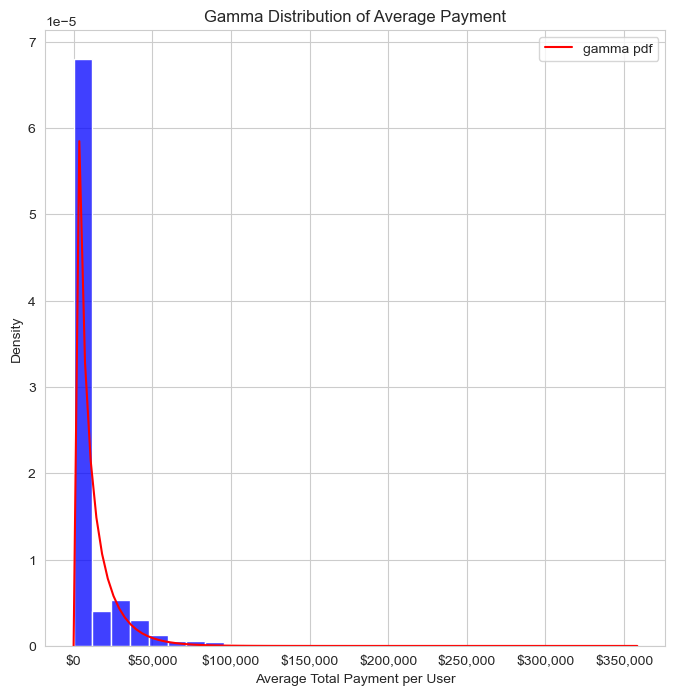

In [61]:
plt.figure(figsize=(8,8))

# extract average total payment per user data
payment_data = cbsa[target_col]

# fit a gamma distribution (to payment data
shape, loc, scale = stats.gamma.fit(payment_data)

# binned histogram with blue line kde
sns.histplot(payment_data, kde=False, color='blue', bins=30, stat='density')

# points for the gamma distribution
x = np.linspace(0, payment_data.max(), 100)
y = stats.gamma.pdf(x, shape, loc, scale)

# plot red line gamma distribution
plt.plot(x, y, 'r-', label='gamma pdf')

# labels
plt.xlabel('Average Total Payment per User')
plt.ylabel('Density')
plt.title('Gamma Distribution of Average Payment')

# format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}'.format(x)
# apply format
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

# plot
plt.legend()
plt.savefig('plot_no_kde.png')
plt.show()

The range of possible values of the random variable is visualized by the gamma distribution curve.

    blue line = kernel density estimate (KDE by sns) plot overlaid on the histogram
    red line = the gamma pdf
    total area under the PDF curve = 1

#### **1. Split Data and validate partitions**

In [62]:
cbsa.shape

(162848, 23)

In [63]:
# use split command to partition the dataset 33% training
train_cbsa, test_cbsa = train_test_split(cbsa, test_size = .33, random_state =7)

In [64]:
train_cbsa.shape, test_cbsa.shape

((109108, 23), (53740, 23))

In [65]:
# confirm proportions
bool(train_cbsa.shape[0] == round(cbsa.shape[0]*.67))

True

In [66]:
# validate partition
targetz_train = train_cbsa[['target_payment']] 
targetz_test = test_cbsa[['target_payment']]

statistic, p_value = ttest_ind(targetz_train, targetz_test)

print("Test statistic:", statistic)
print("p-value:", p_value)

Test statistic: [-0.17448116]
p-value: [0.86148755]


The p value is greater than the significance level of 0.05, therefore, there is no statistically significant difference in the two datasets on the target column. This validates that the training and test sets should be similar on `target_payment`.

#### **2. Isolate target response variable**

In [67]:
# predicting target_payment
y_train = train_cbsa['target_payment']
y_test = test_cbsa['target_payment']

In [68]:
# isolate predictors
main_predictors = ['target_payment','number_of_fee_for_service_beneficiaries',
    'number_of_providers','number_of_users','number_of_dual_eligible_users','cbsa',
    'type_of_service_encoded']

#### **4. Analyze and find correlation between predictors**

PCA - The CBSA dataset with has predictors, contributing to its high dimensionality. Many of these predictors are derived from other columns of the dataset, leading to multicollinearity concerns due to a significant degree of correlation between two or more predictors. To address multicollinearity concerns, dimension reduction techniques are performed. Instead of using derived or calculated predictors, original raw data are used. Redundant variables that do not improve model performance are also removed. For example, variable CBSA values also represent specific city and state variables. The variable that gives more information are kept for analysis.

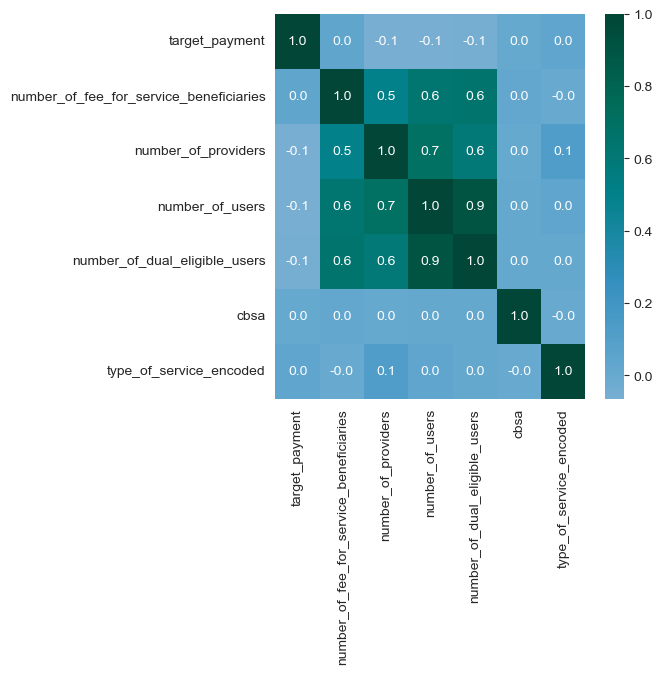

In [69]:
corr = train_cbsa[main_predictors].corr()
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sns.heatmap(corr, annot=True, fmt=".1f", center =0, ax=ax, cmap='PuBuGn')
plt.show()

Because the target variable was divided by number of users, `number_of_users`, `number_of_dual_eligible_users`, and `percentage_of_users_out_of_ffs_beneficiaries` will be removed. The new variable represents the target variable relative to the feature attribute and may not be significant in explaining the variation with the target variable. The categorical variable 'cbsa' will also be removed due to increased in dimensionality of the dataset. Additionally, the CMS claims that cost of health services is the same through all states. Furthermore, the cost of living in the form of health index has been applied to address differnces between states.

## Choose Data Mining Methods

#### 5. Isolate predictors

In [70]:
# predictors by attribute types
# numericals = ['number_of_fee_for_service_beneficiaries', 'number_of_providers','number_of_users']
numericals = ['number_of_providers']
categorical = ['type_of_service']

In [71]:
# ML model of predictors for training
X_train_numerical = train_cbsa[numericals]
X_train_numerical.shape

(109108, 1)

In [72]:
# ML model of predictors for testing
X_test_numerical = test_cbsa[numericals]
X_test_numerical.shape

(53740, 1)

In [73]:
# assess categorical
train_cbsa['type_of_service'].value_counts()

type_of_service
Independent Diagnostic Testing Facility Pt A    5711
Preventive Health Services                      5695
Clinical Laboratory (Billing Independently)     5661
Ophthalmology                                   5656
Pulmonology                                     5630
Home Health                                     5622
Ambulance (Emergency & Non-Emergency)           5620
Ambulance (Emergency)                           5607
Podiatry Services                               5605
Independent Diagnostic Testing Facility Pt B    5568
Psychotherapy                                   5512
Chiropractic Services                           5503
Physical & Occupational Therapy                 5493
Skilled Nursing Facility                        5491
Hospice                                         5380
Ambulance (Non-Emergency)                       5362
Federally Qualified Health Center (FQHC)        5025
Dialysis                                        4700
Cardiac Rehabilitation Program

**Add encoded variables to train and test datasets**

In [74]:
# encode type of service in train data should euqal 21 columns
train_encoded = pd.get_dummies(train_cbsa['type_of_service'])
train_encoded = train_encoded.astype(int)
# train_encoded.drop(columns=['Ambulance (Emergency)', 'Ambulance (Non-Emergency)'], inplace=True)

21 service types, therefore generate additional 21 columns for encoding. May need to combine related categories such as Ambulance

In [75]:
# concatenate dummy with train data
X_train = pd.concat([X_train_numerical, train_encoded], axis=1)
# X_train

In [76]:
# encode for test set
test_encoded = pd.get_dummies(test_cbsa['type_of_service'])
test_encoded = test_encoded.astype(int)
# test_encoded.drop(columns=['Ambulance (Emergency)', 'Ambulance (Non-Emergency)'], inplace=True)

In [77]:
# concatenate dummy with test data
X_test = pd.concat([X_test_numerical, test_encoded], axis=1)
# X_test

$$ \text{Average Payment per User} = b_0 + b_1(\text{number of providers}) + b_2(\text{type of service x 21}) $$


In [78]:
# add constant term to train and test predictors for the linear regression models
X_train_lr = sm.add_constant(X_train)
X_test_lr = sm.add_constant(X_test)

#### **3. Baseline Model for Predicting Adjusted Total Payment with the Average Value of the Dataset**

In [79]:
average_payment = train_cbsa['target_payment'].mean()
baseline_pred = [average_payment]*len(test_cbsa)

# mean absolute error
mean_absolute_error(baseline_pred, y_test)

11480.733584635349

On average, the baseline model prediction is off by $11,480.73

#### **5. Build and validate machine learning models**

Determine which combination of transformation and ML models generate better prediction accuracy

**Gamma Regression #1: Baseline**

In [80]:
# gamma base model
link_function = sm.families.links.log()
# gamma01 = sm.GLM(y_train, X_train_lr, family = sm.families.Gamma(link=sm.families.links.log)).fit()
gamma01 = sm.GLM(y_train, X_train_lr, family = sm.families.Gamma(link=link_function)).fit()

# make predictions on predictor test set with gamma model algo
gamma_base_preds = gamma01.predict(X_test_lr)

# MAE of random forest
mean_absolute_error(y_test, gamma_base_preds)

1802.8031587907772

In [81]:
gamma01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         target_payment   No. Observations:               109108
Model:                            GLM   Df Residuals:                   109086
Model Family:                   Gamma   Df Model:                           21
Link Function:                    log   Scale:                         0.14279
Method:                          IRLS   Log-Likelihood:            -8.1215e+05
Date:                Mon, 15 Apr 2024   Deviance:                       12552.
Time:                        13:54:21   Pearson chi2:                 1.56e+04
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            6.9462      0.001   6152.713      0.000       6.944       6.948
number_of_providers                              0.0001   4.17e-06     28.806      0.000       0.000       0.000
Ambulance (Emergency & Non-Emergency)           -0.1293      0.005    -26.201      0.000      -0.139      -0.120
Ambulance (Emergency)                           -0.3968      0.005    -80.315      0.000      -0.406      -0.387
Ambulance (Non-Emergency)                       -0.2996      0.005    -59.372      0.000      -0.309      -0.290
Cardiac Rehabilitation Program                   2.5938      0.006    451.722      0.000       2.583       2.605
Chiropractic Services                           -1.4016      0.005   -281.267      0.000      -1.411      -1.392
Clinical Laboratory (Billing Independently)     -1.4180      0.005   -288.441      0.000      -1.428      -1.408
Dialysis                                         3.7992      0.005    706.922      0.000       3.789       3.810
Federally Qualified Health Center (FQHC)        -0.1092      0.005    -20.973      0.000      -0.119      -0.099
Home Health                                      2.2103      0.005    447.974      0.000       2.201       2.220
Hospice                                          3.1299      0.005    621.131      0.000       3.120       3.140
Independent Diagnostic Testing Facility Pt A     1.4842      0.005    303.137      0.000       1.475       1.494
Independent Diagnostic Testing Facility Pt B    -1.1321      0.005   -228.387      0.000      -1.142      -1.122
Long-Term Care Hospitals                         4.4483      0.007    615.216      0.000       4.434       4.462
Ophthalmology                                   -0.6606      0.005   -134.255      0.000      -0.670      -0.651
Physical & Occupational Therapy                 -0.3631      0.005    -72.779      0.000      -0.373      -0.353
Podiatry Services                               -1.7673      0.005   -357.755      0.000      -1.777      -1.758
Preventive Health Services                      -1.9879      0.005   -396.808      0.000      -1.998      -1.978
Psychotherapy                                   -0.7686      0.005   -154.364      0.000      -0.778      -0.759
Pulmonology                                     -1.9486      0.005   -391.700      0.000      -1.958      -1.939
Skilled Nursing Facility                         3.3717      0.005    675.777      0.000       3.362       3.382
Telemedicine                                    -1.7084      0.006   -280.734      0.000      -1.720      -1.696
================================================================================================================
"""

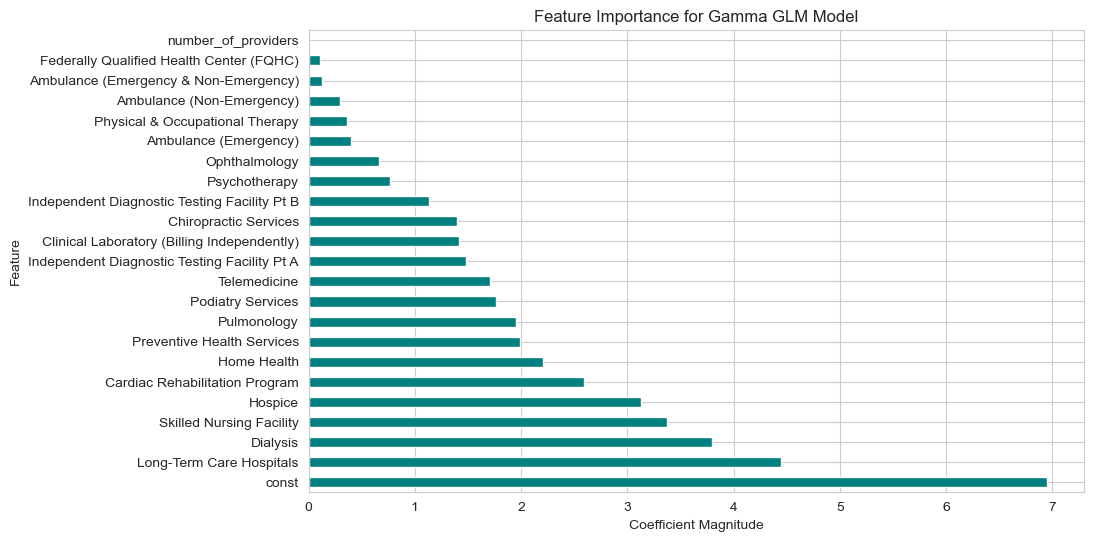

In [82]:
coefficients = gamma01.params

# Sort the coefficients by absolute value to get feature importance
feature_importance = coefficients.abs().sort_values(ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh', color='teal')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance for Gamma GLM Model')
plt.show()

**Gamma Regression #2: Standardized**

In [83]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_gamma_pipeline1 = Pipeline(steps=[('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=22)),
    ('Gamma', GammaRegressor())])
scale_pca_gamma_pipeline1

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=22)),
                ('Gamma', GammaRegressor())])

In [84]:
# fit the pipeline model to the training data
scale_pca_gamma_pipeline1.fit(X_train_lr, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_gamma_pipeline1_test_preds = scale_pca_gamma_pipeline1.predict(X_test_lr)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_gamma_pipeline1_test_preds)

5545.373281372994

**Gamma Regression #3: Normalized**

In [85]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_gamma_pipeline1 = Pipeline(steps=[('Scaler', Normalizer()),
    ('PCA', PCA(n_components=22)),
    ('Gamma', GammaRegressor())])
scale_pca_gamma_pipeline1

Pipeline(steps=[('Scaler', Normalizer()), ('PCA', PCA(n_components=22)),
                ('Gamma', GammaRegressor())])

In [86]:
# fit the pipeline model to the training data
scale_pca_gamma_pipeline1.fit(X_train_lr, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_gamma_pipeline1_test_preds = scale_pca_gamma_pipeline1.predict(X_test_lr)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_gamma_pipeline1_test_preds)

11107.885765602834

**Gamma Regression #4: PCA 2**

In [87]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_gamma_pipeline = Pipeline(steps=[
    ('PCA', PCA(n_components=12)),
    ('Gamma', GammaRegressor())])
scale_pca_gamma_pipeline

Pipeline(steps=[('PCA', PCA(n_components=12)), ('Gamma', GammaRegressor())])

In [88]:
# fit the pipeline model to the training data
scale_pca_gamma_pipeline.fit(X_train_lr, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_gamma_pipeline_test_preds = scale_pca_gamma_pipeline.predict(X_test_lr)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_gamma_pipeline_test_preds)

11480.733584635356

**Linear Regression #1: Baseline**

In [89]:
lr01 = sm.OLS(y_train, X_train_lr).fit()

# make predictions on predictor test set with lr model algo
lr01_base_preds = lr01.predict(X_test_lr)

# MAE of random forest
mean_absolute_error(y_test, lr01_base_preds)

1806.2400417902536

**Linear Regression #2: Standardized**

In [90]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_lr_pipeline1 = Pipeline(steps=[('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=22)),
    ('LR', LinearRegression())])
scale_pca_lr_pipeline1

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=22)),
                ('LR', LinearRegression())])

In [91]:
# fit the pipeline model to the training data
scale_pca_lr_pipeline1.fit(X_train_lr, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_lr_pipeline1_test_preds = scale_pca_lr_pipeline1.predict(X_test_lr)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_lr_pipeline1_test_preds)

1806.3171892108774

StandardScaler is closer to baseline.

**Linear Regression #3: Normalized**

In [92]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_lr_pipeline2 = Pipeline(steps=[('Scaler', Normalizer()),
    ('PCA', PCA(n_components=22)),
    ('LR', LinearRegression())])
scale_pca_lr_pipeline2

Pipeline(steps=[('Scaler', Normalizer()), ('PCA', PCA(n_components=22)),
                ('LR', LinearRegression())])

In [93]:
# fit the pipeline model to the training data
scale_pca_lr_pipeline2.fit(X_train_lr, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_lr_pipeline2_test_preds = scale_pca_lr_pipeline2.predict(X_test_lr)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_lr_pipeline2_test_preds)

5003.410981165605

**Linear Regression #4: PCA = 2**

In [94]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_forest_pipeline = Pipeline(steps=[('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=4)),
    ('Forest', RandomForestRegressor(n_estimators=50, max_depth=5))])
scale_pca_forest_pipeline

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=4)),
                ('Forest',
                 RandomForestRegressor(max_depth=5, n_estimators=50))])

In [95]:
# fit the pipeline model to the training data
scale_pca_forest_pipeline.fit(X_train, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_forest_pipeline_test_preds = scale_pca_forest_pipeline.predict(X_test)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_forest_pipeline_test_preds)

3295.0363567800705

Standard Scaler is a better transformation to apply on predictors.

**Random Forest Regressor #1: Baseline**

In [96]:
# fit the random forest regressor model to the training sets (predictors, and target y)
forest_base = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_lr, y_train)

# make predictions on predictor test set with random forest model algo
forest_base_preds = forest_base.predict(X_test_lr)

# MAE of random forest
mean_absolute_error(y_test, forest_base_preds)

2749.4341627497242

In [97]:
# fit the random forest regressor model to the training sets (predictors, and target y)
forest_base = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train, y_train)

# make predictions on predictor test set with random forest model algo
forest_base_preds = forest_base.predict(X_test)

# MAE of random forest
mean_absolute_error(y_test, forest_base_preds)

2747.8369184985895

In [98]:
# feature importances
feature_importances = forest_base.feature_importances_

# Create a DataFrame to store feature importances along with column names
column_names = X_test.columns
importance_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importances})

# importance_df

    Dialysis = 0.247076
    Long-Term Care Hospitals = 0.532583
    Skilled Nursing Facility = 0.121291

**Random Forest Regressor #2: Normalized**

In [99]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_forest_pipeline = Pipeline(steps=[('Scaler', Normalizer()),
    ('PCA', PCA(n_components=2)),
    ('Forest', RandomForestRegressor(n_estimators=50, max_depth=5))])
scale_pca_forest_pipeline

Pipeline(steps=[('Scaler', Normalizer()), ('PCA', PCA(n_components=2)),
                ('Forest',
                 RandomForestRegressor(max_depth=5, n_estimators=50))])

In [100]:
# fit the pipeline model to the training data
scale_pca_forest_pipeline.fit(X_train, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_forest_pipeline_test_preds = scale_pca_forest_pipeline.predict(X_test)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_forest_pipeline_test_preds)

5760.918329745174

**Determine which combination of transformation and ML models generate better prediction accuracy**

## Apply Methods and Select Final Model

**Gamma Regression**

In [101]:
# gamma base model
gamma01 = sm.GLM(y_train, X_train_lr, family = sm.families.Gamma()).fit()

# make predictions on predictor test set with gamma model algo
gamma_base_preds = gamma01.predict(X_test_lr)

# MAE of random forest
mean_absolute_error(y_test, gamma_base_preds)

1801.2535788995806

## Evaluate Performance

In [102]:
# Function to calculate model evaluation metrics
def evaluate_model(y_true, y_pred):
    # Calculate R-squared
    r2 = r2_score(y_true, y_pred)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)

    # Calculate Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate Mean Percentage Error
    mpe = np.mean((y_true - y_pred) / y_true) * 100

    # Calculate Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MPE': mpe, 'MAPE': mape}

# Models' predictions
models_preds = {'Gamma Regression': gamma_base_preds, 
                'Linear Regression': lr01_base_preds, 
                'Random Forest': forest_base_preds}

# Evaluate each model
results = {}
for model_name, preds in models_preds.items():
    results[model_name] = evaluate_model(y_test, preds)

# Print results
for model_name, metrics in results.items():
    print(f"{model_name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()

Gamma Regression Results:
R2: 0.9097234895508856
MSE: 29092651.56826666
RMSE: 5393.76042926145
MAE: 1801.2535788995806
MPE: -13.188638814974396
MAPE: 28.573685961260427

Linear Regression Results:
R2: 0.9097577795783557
MSE: 29081601.20957986
RMSE: 5392.735966981868
MAE: 1806.2400417902536
MPE: -12.644216664903677
MAPE: 29.05061455008481

Random Forest Results:
R2: 0.8976332640745377
MSE: 32988866.823102314
RMSE: 5743.593546126181
MAE: 2747.8369184985895
MPE: -252.97286791485791
MAPE: 272.59676870631716



| Model                | R2                 | MSE            | RMSE          | MAE            | MPE            | MAPE           |
|----------------------|--------------------|----------------|---------------|----------------|----------------|----------------|
| Gamma Regression     | 0.9097             | 29092651.57    | 5393.760      | 1801.254       | -13.189        | 28.574         |
| Linear Regression    | 0.9098             | 29081601.21    | 5392.736      | 1806.240       | -12.644        | 29.051         |
| Random Forest        | 0.8976             | 32999491.86    | 5744.518      | 2747.514       | -252.538       | 272.161        |

**Creating Predictions on all select predictors of original dataset `cbsa` forClassification Analysis**

In [103]:
X = cbsa[numericals]
X.shape

(162848, 1)

In [104]:
# encode categorical
cbsa_encoded = pd.get_dummies(cbsa['type_of_service'])
cbsa_encoded = cbsa_encoded.astype(int)

# combine with original unsplit dataset
X = pd.concat([X, cbsa_encoded], axis=1)
X = sm.add_constant(X)

In [105]:
# create new dataset containing the original dataset and the encoded X for prediction
cbsa2 = pd.concat([cbsa, cbsa_encoded], axis=1)
cbsa2.shape

(162848, 44)

In [106]:
# create new column and apply to cbsa containing the original dataset
cbsa2['predicted_average_payment'] = gamma01.predict(X)

In [107]:
cbsa2.shape

(162848, 45)

In [108]:
# perform transformation and create additional column to populate output of transformation
cbsa2['Q1'] = cbsa2.groupby('type_of_service')['target_payment'].transform(lambda x: x.quantile(0.25))
cbsa2['Q3'] = cbsa2.groupby('type_of_service')['target_payment'].transform(lambda x: x.quantile(0.75))

# prediction column on cbsa2
cbsa2['in_range'] = (cbsa2['predicted_average_payment'] >= cbsa2['Q1']) & (cbsa2['predicted_average_payment'] <= cbsa2['Q3'])

In [109]:
# format state column for mapping
cbsa2['state1'] = cbsa2['state'].str[:2]

In [110]:
# dictionary for time zone which will be used for categorical analysis in clustering task
state_time_zone_mapping = {
    'AK': 'alaska', 'AL': 'central', 'AR': 'central', 'AZ': 'pacific', 'CA': 'pacific',
    'CO': 'mountain', 'CT': 'eastern', 'DC': 'eastern', 'DE': 'eastern', 'FL': 'eastern',
    'GA': 'eastern', 'HI': 'hawaii', 'IA': 'central', 'ID': 'mountain', 'IL': 'central',
    'IN': 'eastern', 'KS': 'central', 'KY': 'eastern', 'LA': 'central', 'MA': 'eastern',
    'MD': 'eastern', 'ME': 'eastern', 'MI': 'eastern', 'MN': 'central', 'MO': 'central',
    'MS': 'central', 'MT': 'mountain', 'NC': 'eastern', 'ND': 'central', 'NE': 'central',
    'NH': 'eastern', 'NJ': 'eastern', 'NM': 'mountain', 'NV': 'pacific', 'NY': 'eastern',
    'OH': 'eastern', 'OK': 'central', 'OR': 'pacific', 'PA': 'eastern', 'RI': 'eastern',
    'SC': 'eastern', 'SD': 'central', 'TN': 'central', 'TX': 'central', 'UT': 'mountain',
    'VA': 'eastern', 'VT': 'eastern', 'WA': 'pacific', 'WI': 'central', 'WV': 'eastern',
    'WY': 'mountain', 'PR': 'atlantic'
}

# new column 'zone' by mapping the state1 column to time zone categories
cbsa2['zone'] = cbsa2['state1'].map(state_time_zone_mapping)
# cbsa2

In [111]:
# warning: do not encode before splitting
# zone_encoded = pd.get_dummies(cbsa2['zone'])
# zone_encoded = zone_encoded.astype(int)

# cbsa2 = pd.concat([cbsa2, zone_encoded], axis=1)

In [112]:
cbsa2.columns

Index(['type_of_service', 'cbsa', 'start_date', 'end_date', 'city', 'state',
       'aggregation_level', 'cbsatitle',
       'number_of_fee_for_service_beneficiaries', 'number_of_providers',
       'average_number_of_users_per_provider',
       'percentage_of_users_out_of_ffs_beneficiaries', 'number_of_users',
       'average_number_of_providers_per_cbsa', 'number_of_dual_eligible_users',
       'percentage_of_dual_eligible_users_out_of_total_users',
       'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries',
       'total_payment', 'year', 'type_of_service_encoded',
       'cost_of_health_index', 'total_payment_adjusted', 'target_payment',
       'Ambulance (Emergency & Non-Emergency)', 'Ambulance (Emergency)',
       'Ambulance (Non-Emergency)', 'Cardiac Rehabilitation Program',
       'Chiropractic Services', 'Clinical Laboratory (Billing Independently)',
       'Dialysis', 'Federally Qualified Health Center (FQHC)', 'Home Health',
       'Hospice', 'Independe

In [113]:
# subset numerical and not encoded variables
cbsa2 = cbsa2[['number_of_providers','zone', 'in_range']]
# cbsa2

In [114]:
cbsa2.to_csv('cbsa2.csv', index=False)

## **References**

Larose, C., & Larose, D. (2019). Data science using Python and R. John Wiley & Sons, Inc. 

Tan, P. N., Steinbach, M., Karpatne, A., & Kumar, V. (2019). Introduction to data mining (2nd ed.). Pearson.

AI RA.

https://data.cms.gov/summary-statistics-on-use-and-payments/program-integrity-market-saturation-by-type-of-service/market-saturation-utilization-core-based-statistical-areas

https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.html

https://meric.mo.gov/data/cost-living-data-series
